# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [85]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt

plt_interval = 50

transform = transforms.Compose(
   [transforms.ToTensor()])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('cat', 'dog', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 3; label2 = 5 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# Grayscale and vectorize images
trainset.train_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in trainset.train_data])
testset.test_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testset.test_data])
print("Dimensions of grayscaled vectorized images:", np.shape(trainset.train_data))

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Dimensions of grayscaled vectorized images: (20000, 32, 32)
Data loaded:
- Training set size: 20000
- Test set size: 2000


Test Images:


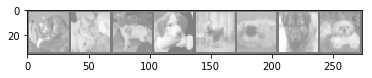

truck truck   dog   dog   dog   dog   dog   dog
Train Images:


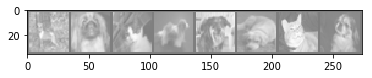

  dog   dog truck   dog   dog   dog truck   dog


In [86]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [125]:
# set learning rate
eta = 1

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [126]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time)

# Online BBM 

In [127]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    gamma = 0.05
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 0 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
                
    return n_mistakes_over_time

# AdaBoost OL

In [128]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [129]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        with torch.no_grad():
            for data in testloader:
                x, y = data
                x = x.numpy().flatten()
                prediction = predict_WL(weak_learners, x, i)
                correct += (prediction == y).sum().item()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    with torch.no_grad():
        for data in testloader: 
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL_alg1(weak_learners, x)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
            correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [130]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(architecture, T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(1024)
    mistakes = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, architecture):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
    
    # test
    mistakes = onlineBBM(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, architecture):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 10000 iterations: 0.4814
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 50 %


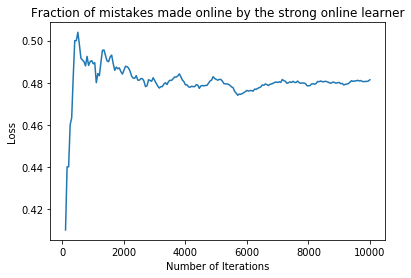

In [131]:
evaluate_baseline(architecture=0, T=10000)

## Online BBM

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.486
Fraction of mistakes by time 2000 0.4865
Fraction of mistakes by time 3000 0.49033333333333334
Fraction of mistakes by time 4000 0.49225
Fraction of mistakes by time 5000 0.488
Fraction of mistakes by time 6000 0.48583333333333334
Fraction of mistakes by time 7000 0.48614285714285715
Fraction of mistakes by time 8000 0.48275
Fraction of mistakes by time 9000 0.4845555555555556
Fraction of mistakes by time 10000 0.483
Fraction of mistakes after 10000 iterations: 0.483
Edges of weak learners:
 [0.017  0.017  0.017  0.0014 0.0014]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 50 %
Accuracy of weak learner 1 on the 2000 test images: 50 %
Accuracy of weak learner 2 on the 2000 test images: 50 %
Accuracy of weak learner 3 on the 2000 test images: 50 %
Accuracy of weak learner 4 on the 2000 test images: 50 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 50 %


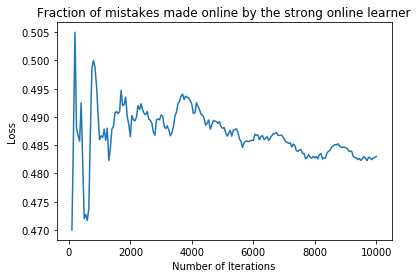

In [132]:
evaluate_onlineBBM(N=5, T=10000, architecture=2)

## Adaboost.OL

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.485
Fraction of mistakes by time 2000 0.4895
Fraction of mistakes by time 3000 0.481
Fraction of mistakes by time 4000 0.484
Fraction of mistakes by time 5000 0.4784
Fraction of mistakes after 5000 iterations: 0.4784
Edges of weak learners:
 [0.0318 0.0278 0.021  0.0248 0.0166]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 52 %
Accuracy of weak learner 1 on the 2000 test images: 50 %
Accuracy of weak learner 2 on the 2000 test images: 54 %
Accuracy of weak learner 3 on the 2000 test images: 50 %
Accuracy of weak learner 4 on the 2000 test images: 49 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 52 %


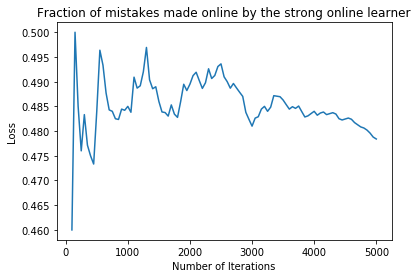

In [133]:
evaluate_adaboostOL(N=5, T=5000, architecture=2)

## Run Experiments

In [21]:
def run_experiment(T=10000, N=10, net=0, model="bbm"):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, net)
    
# ignore net input

In [ ]:
run_experiment(T=20000, N=5, net=0, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf